In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


X diff Scaler

Y diff Scaler

First Split

Then Scalling

from tensorflow.keras.models import load_model


In [ ]:
# !pip install --upgrade tensorflow
# !pip install --upgrade keras

In [ ]:
import numpy as np
import pandas as pd
# import keras_tuner as kt
from matplotlib import pyplot as plt
import tensorflow as tf
from prophet import Prophet
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import InputLayer, Dense, LSTM, Dropout,GRU
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import seaborn as sns
import os
import datetime
import cv2

In [ ]:
folder_path = (r"/content/drive/MyDrive/MTech Internship/guj_adani_subset.csv")
df = pd.read_csv(folder_path)
# print(df.head(20))

df['date_time'] = pd.to_datetime(df['date_time'])
df = df[(df['date_time'].dt.time >= pd.to_datetime('7:00').time()) &
                  (df['date_time'].dt.time <= pd.to_datetime('19:30').time())]

In [ ]:
starting_timestamp = "01/01/2023 0:00"
ending_timestamp = "12/31/2023 23:30"
array_range = pd.date_range(start=starting_timestamp, end=ending_timestamp, freq='30T')

array_timestamps = []

start_time = pd.to_datetime("7:00 AM").time()
end_time = pd.to_datetime("7:00 PM").time()
max_end_time = pd.to_datetime("7:30 PM").time()

for timestamp in array_range:
    if timestamp.time() >= start_time and timestamp.time() <= end_time:
        array_timestamps.append(timestamp)
    elif timestamp.time() > end_time and timestamp.time() <= max_end_time:
        array_timestamps.append(timestamp)


df_date = pd.DataFrame({'date_time':array_timestamps})
df_date.set_index('date_time')
p_df = pd.merge(df_date, df, on = 'date_time', how='left')
# print(p_df.head(60))
# print(df.head(20))


cols = list(p_df)[1:4]
print(cols)

df_for_training = p_df[cols].astype(float)
        # print(df_for_training.head(10))
df_for_training = df_for_training.dropna()
# df_for_training.to_csv(os.path.join(base_dir,"interpolated_file.csv"),header=True)
print(df_for_training.head(40))
print(df_for_training.shape)
# df_for_training = np.array(df_for_training).reshape(-1,1)
# print(df_for_training.shape)

['ghi', 'swir', 'vis']
           ghi   swir    vis
0     0.353333   18.0   16.0
1    16.586666   18.0   17.0
2    77.518330   19.0   21.0
3   174.731670   28.0   28.0
4   281.553340   49.0   46.0
5   382.408330   35.0   36.0
6   464.021670   35.0   37.0
7   538.681640   40.0   39.0
8   596.518300   39.0   39.0
9   656.218300   37.0   41.0
10  707.650000   48.0   37.0
11  744.750000   41.0   39.0
12  757.936650  188.0  115.0
13  735.298340  123.0   55.0
14  710.201660  154.0  116.0
15  664.753360  115.0   80.0
16  599.985000  130.0   83.0
17  509.203340   49.0   39.0
18  421.646670   71.0   54.0
19  314.725000   95.0   54.0
20  199.021670   77.0   58.0
21   84.186670   75.0   51.0
22    7.995000   92.0   55.0
23    0.000000   64.0   48.0
24    0.000000   50.0   39.0
25    0.000000   50.0   47.0
26    0.313333   12.0   18.0
27   16.440000   15.0   20.0
28   76.815000   23.0   20.0
29  176.768330   27.0   31.0
30  282.428340   44.0   44.0
31  384.903320   38.0   39.0
32  467.208340   54.

<ipython-input-35-f2d36d164ef7>:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  array_range = pd.date_range(start=starting_timestamp, end=ending_timestamp, freq='30T')


In [ ]:
def missingValUsingMedian(missing_val_date):

    print("Neighbouring values not available")
    print("Find previous 5 days values and perform median operation")

    dt = missing_val_date
    prev_dates_lst = []
    prev_values_lst = []
    for k in range(5):
        dt1 = dt - datetime.timedelta(days=k+1)
        dt_str = dt1.strftime("%Y-%m-%d %H:%M")
        prev_dates_lst.append(dt_str)
        value = df[df['date_time'] == dt_str][col].values[0]
        if value != None:
            print(value)
            prev_values_lst.append(value)
    print(prev_values_lst)
    missing_val = np.nanmedian(prev_values_lst)
    print(missing_val)

    return missing_val

for col in p_df.columns:
    print(col)
    for i, row in p_df.iterrows():
        dt = row[0]
        if i==0:
            pass
        else:
            if pd.isnull(p_df.loc[i][col]):
                print("Value null for dt::",row[0])
                if not pd.isnull(p_df.loc[i-1][col]):
                    if not pd.isnull(p_df.loc[i+1][col]):
                        p_df.loc[i,col] = (p_df.loc[i-1][col] + p_df.loc[i+1][col])/2
                        print(p_df.loc[i, col])
                        # p_df[col].replace(p_df.loc[i,col], new_val, inplace = True)
                        print("Replaced Value:", p_df.loc[i, col])

                    elif not pd.isnull(p_df.loc[i+2][col]):
                        print("here--1")
                        p_df.loc[i,col] = (p_df.loc[i-1][col] + p_df.loc[i+2][col])/2
                        # p_df.replace(p_df.loc[i,col], new_val, inplace = True)
                    else:
                        replaced_val = missingValUsingMedian(dt)
                        print("missing Values::",replaced_val)
                        p_df.loc[i,col]= replaced_val
                        p_df.replace(p_df.loc[i,col], replaced_val, inplace = True)
                        print("Replaced Value:", p_df.loc[i, col])
                else:
                    replaced_val = missingValUsingMedian(dt)
                    print("missing Values::",replaced_val)
                    p_df.loc[i,col]= replaced_val
                    # p_df.replace(p_df.loc[i,col], replaced_val, inplace = True)
                    print("Replaced Value:", p_df.loc[i, col])



date_time


<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]


ghi


<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]


swir
Value null for dt:: 2023-01-04 12:00:00
120.5
Replaced Value: 120.5
Value null for dt:: 2023-01-06 14:00:00
79.5
Replaced Value: 79.5
Value null for dt:: 2023-01-08 13:30:00
53.5
Replaced Value: 53.5
Value null for dt:: 2023-01-10 12:30:00
here--1
Value null for dt:: 2023-01-10 13:00:00
78.25
Replaced Value: 78.25
Value null for dt:: 2023-01-11 09:00:00
36.0
Replaced Value: 36.0
Value null for dt:: 2023-01-14 07:30:00
21.0
Replaced Value: 21.0
Value null for dt:: 2023-01-15 08:00:00
27.5
Replaced Value: 27.5
Value null for dt:: 2023-01-16 07:00:00
41.5
Replaced Value: 41.5
Value null for dt:: 2023-01-17 07:30:00
here--1
Value null for dt:: 2023-01-17 08:00:00
20.5
Replaced Value: 20.5
Value null for dt:: 2023-01-18 14:00:00
108.5
Replaced Value: 108.5
Value null for dt:: 2023-01-19 09:00:00
28.5
Replaced Value: 28.5
Value null for dt:: 2023-01-19 18:30:00
131.5
Replaced Value: 131.5
Value null for dt:: 2023-01-20 14:00:00
82.0
Replaced Value: 82.0
Value null for dt:: 2023-01-21 09

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

24.0
26.0
23.0
27.0
[24.0, 24.0, 26.0, 23.0, 27.0]
24.0
missing Values:: 24.0
Replaced Value: 24.0
Value null for dt:: 2023-02-09 09:00:00
here--1
Value null for dt:: 2023-02-09 09:30:00
42.75
Replaced Value: 42.75
Value null for dt:: 2023-02-10 13:30:00
65.5
Replaced Value: 65.5
Value null for dt:: 2023-02-10 14:30:00
77.5
Replaced Value: 77.5
Value null for dt:: 2023-02-11 14:00:00
158.5
Replaced Value: 158.5
Value null for dt:: 2023-02-12 11:00:00
82.0
Replaced Value: 82.0
Value null for dt:: 2023-02-12 14:30:00
here--1
Value null for dt:: 2023-02-12 15:00:00
133.25
Replaced Value: 133.25
Value null for dt:: 2023-02-12 19:30:00
50.0
Replaced Value: 50.0
Value null for dt:: 2023-02-13 14:00:00
103.0
Replaced Value: 103.0
Value null for dt:: 2023-02-14 12:00:00
58.0
Replaced Value: 58.0
Value null for dt:: 2023-02-15 12:00:00
117.0
Replaced Value: 117.0
Value null for dt:: 2023-02-17 14:00:00
41.5
Replaced Value: 41.5
Value null for dt:: 2023-02-17 19:00:00
87.5
Replaced Value: 87.5
V

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

66.0
195.0
80.0
[38.0, 38.0, 66.0, 195.0, 80.0]
66.0
missing Values:: 66.0
Replaced Value: 66.0
Value null for dt:: 2023-03-23 12:00:00
Neighbouring values not available
Find previous 5 days values and perform median operation
33.0
37.0
186.0
187.0
54.0
[33.0, 37.0, 186.0, 187.0, 54.0]
54.0
missing Values:: 54.0
Replaced Value: 54.0
Value null for dt:: 2023-03-23 12:30:00
Neighbouring values not available
Find previous 5 days values and perform median operation
32.0
nan
127.0
180.0
74.0
[32.0, nan, 127.0, 180.0, 74.0]
100.5
missing Values:: 100.5
Replaced Value: 100.5
Value null for dt:: 2023-03-23 13:00:00
Neighbouring values not available
Find previous 5 days values and perform median operation
35.0
36.0
97.0
166.0
94.0
[35.0, 36.0, 97.0, 166.0, 94.0]
94.0
missing Values:: 94.0
Replaced Value: 94.0
Value null for dt:: 2023-03-23 13:30:00
here--1
Value null for dt:: 2023-03-23 14:00:00
62.5
Replaced Value: 62.5
Value null for dt:: 2023-03-24 07:30:00
15.5
Replaced Value: 15.5
Value nu

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

Value null for dt:: 2023-04-24 08:30:00
23.0
Replaced Value: 23.0
Value null for dt:: 2023-04-25 16:30:00
166.5
Replaced Value: 166.5
Value null for dt:: 2023-04-26 12:00:00
67.0
Replaced Value: 67.0
Value null for dt:: 2023-04-26 16:30:00
95.0
Replaced Value: 95.0
Value null for dt:: 2023-04-30 09:30:00
here--1
Value null for dt:: 2023-04-30 10:00:00
80.25
Replaced Value: 80.25
Value null for dt:: 2023-04-30 14:00:00
229.5
Replaced Value: 229.5
Value null for dt:: 2023-05-01 14:30:00
55.5
Replaced Value: 55.5
Value null for dt:: 2023-05-02 15:00:00
Neighbouring values not available
Find previous 5 days values and perform median operation
57.0
248.0
52.0
63.0
48.0
[57.0, 248.0, 52.0, 63.0, 48.0]
57.0
missing Values:: 57.0
Replaced Value: 57.0
Value null for dt:: 2023-05-02 15:30:00
here--1
Value null for dt:: 2023-05-02 16:00:00
143.25
Replaced Value: 143.25
Value null for dt:: 2023-05-03 07:00:00
51.5
Replaced Value: 51.5
Value null for dt:: 2023-05-03 12:00:00
71.5
Replaced Value: 71

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

67.5
Replaced Value: 67.5
Value null for dt:: 2023-06-19 12:00:00
41.0
Replaced Value: 41.0
Value null for dt:: 2023-06-19 19:00:00
51.5
Replaced Value: 51.5
Value null for dt:: 2023-06-20 16:30:00
164.0
Replaced Value: 164.0
Value null for dt:: 2023-06-21 12:00:00
47.0
Replaced Value: 47.0
Value null for dt:: 2023-06-21 14:00:00
66.5
Replaced Value: 66.5
Value null for dt:: 2023-06-21 18:30:00
here--1
Value null for dt:: 2023-06-21 19:00:00
60.0
Replaced Value: 60.0
Value null for dt:: 2023-06-23 14:00:00
72.0
Replaced Value: 72.0
Value null for dt:: 2023-06-25 14:00:00
49.0
Replaced Value: 49.0
Value null for dt:: 2023-06-25 18:30:00
70.5
Replaced Value: 70.5
Value null for dt:: 2023-06-26 14:00:00
46.0
Replaced Value: 46.0
Value null for dt:: 2023-06-28 18:00:00
here--1
Value null for dt:: 2023-06-28 18:30:00
67.0
Replaced Value: 67.0
Value null for dt:: 2023-06-30 11:30:00
59.0
Replaced Value: 59.0
Value null for dt:: 2023-06-30 15:30:00
85.5
Replaced Value: 85.5
Value null for dt:

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

170.25
Replaced Value: 170.25
Value null for dt:: 2023-07-22 09:00:00
31.0
Replaced Value: 31.0
Value null for dt:: 2023-07-22 11:00:00
43.5
Replaced Value: 43.5
Value null for dt:: 2023-07-22 14:00:00
here--1
Value null for dt:: 2023-07-22 14:30:00
82.5
Replaced Value: 82.5
Value null for dt:: 2023-07-22 17:30:00
67.5
Replaced Value: 67.5
Value null for dt:: 2023-07-23 07:00:00
49.5
Replaced Value: 49.5
Value null for dt:: 2023-07-23 09:00:00
41.0
Replaced Value: 41.0
Value null for dt:: 2023-07-23 13:00:00
68.0
Replaced Value: 68.0
Value null for dt:: 2023-07-23 18:30:00
61.0
Replaced Value: 61.0
Value null for dt:: 2023-07-23 19:30:00
37.0
Replaced Value: 37.0
Value null for dt:: 2023-07-24 10:30:00
here--1
Value null for dt:: 2023-07-24 11:00:00
44.25
Replaced Value: 44.25
Value null for dt:: 2023-07-24 12:30:00
here--1
Value null for dt:: 2023-07-24 13:00:00
48.75
Replaced Value: 48.75
Value null for dt:: 2023-07-25 07:00:00
Neighbouring values not available
Find previous 5 days v

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

133.5
Replaced Value: 133.5
Value null for dt:: 2023-08-20 12:30:00
100.5
Replaced Value: 100.5
Value null for dt:: 2023-08-21 08:30:00
22.0
Replaced Value: 22.0
Value null for dt:: 2023-08-22 14:00:00
50.0
Replaced Value: 50.0
Value null for dt:: 2023-08-23 12:00:00
45.0
Replaced Value: 45.0
Value null for dt:: 2023-08-23 15:00:00
54.5
Replaced Value: 54.5
Value null for dt:: 2023-08-27 08:30:00
27.0
Replaced Value: 27.0
Value null for dt:: 2023-08-27 15:00:00
62.5
Replaced Value: 62.5
Value null for dt:: 2023-08-28 12:00:00
50.5
Replaced Value: 50.5
Value null for dt:: 2023-08-28 16:30:00
90.5
Replaced Value: 90.5
Value null for dt:: 2023-08-28 17:30:00
90.0
Replaced Value: 90.0
Value null for dt:: 2023-08-29 09:30:00
82.0
Replaced Value: 82.0
Value null for dt:: 2023-08-29 14:30:00
174.0
Replaced Value: 174.0
Value null for dt:: 2023-08-29 18:30:00
106.0
Replaced Value: 106.0
Value null for dt:: 2023-08-30 14:00:00
53.0
Replaced Value: 53.0
Value null for dt:: 2023-08-30 17:00:00
10

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

49.5
Replaced Value: 49.5
Value null for dt:: 2023-09-18 13:00:00
62.5
Replaced Value: 62.5
Value null for dt:: 2023-09-18 14:00:00
70.5
Replaced Value: 70.5
Value null for dt:: 2023-09-21 16:30:00
183.0
Replaced Value: 183.0
Value null for dt:: 2023-09-23 12:30:00
here--1
Value null for dt:: 2023-09-23 13:00:00
62.0
Replaced Value: 62.0
Value null for dt:: 2023-09-23 14:00:00
62.0
Replaced Value: 62.0
Value null for dt:: 2023-09-23 15:30:00
84.5
Replaced Value: 84.5
Value null for dt:: 2023-09-24 12:30:00
here--1
Value null for dt:: 2023-09-24 13:00:00
50.0
Replaced Value: 50.0
Value null for dt:: 2023-09-24 15:30:00
113.0
Replaced Value: 113.0
Value null for dt:: 2023-09-25 08:30:00
58.5
Replaced Value: 58.5
Value null for dt:: 2023-09-25 16:00:00
113.5
Replaced Value: 113.5
Value null for dt:: 2023-09-26 11:30:00
Neighbouring values not available
Find previous 5 days values and perform median operation
51.0
50.0
51.0
64.0
66.0
[51.0, 50.0, 51.0, 64.0, 66.0]
51.0
missing Values:: 51.

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

139.5
Replaced Value: 139.5
Value null for dt:: 2023-10-17 14:00:00
178.5
Replaced Value: 178.5
Value null for dt:: 2023-10-18 12:00:00
78.5
Replaced Value: 78.5
Value null for dt:: 2023-10-19 14:00:00
46.5
Replaced Value: 46.5
Value null for dt:: 2023-10-20 14:00:00
53.5
Replaced Value: 53.5
Value null for dt:: 2023-10-20 15:30:00
107.5
Replaced Value: 107.5
Value null for dt:: 2023-10-21 14:00:00
49.0
Replaced Value: 49.0
Value null for dt:: 2023-10-23 15:00:00
71.5
Replaced Value: 71.5
Value null for dt:: 2023-10-24 14:00:00
41.0
Replaced Value: 41.0
Value null for dt:: 2023-10-24 16:30:00
155.5
Replaced Value: 155.5
Value null for dt:: 2023-10-25 11:30:00
46.0
Replaced Value: 46.0
Value null for dt:: 2023-10-26 12:00:00
44.0
Replaced Value: 44.0
Value null for dt:: 2023-10-26 15:00:00
67.5
Replaced Value: 67.5
Value null for dt:: 2023-10-27 14:00:00
52.5
Replaced Value: 52.5
Value null for dt:: 2023-10-27 18:30:00
59.0
Replaced Value: 59.0
Value null for dt:: 2023-10-28 14:00:00
47

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

33.5
Replaced Value: 33.5
Value null for dt:: 2023-11-18 15:00:00
107.5
Replaced Value: 107.5
Value null for dt:: 2023-11-19 17:30:00
97.0
Replaced Value: 97.0
Value null for dt:: 2023-11-20 08:30:00
66.0
Replaced Value: 66.0
Value null for dt:: 2023-11-21 14:00:00
45.0
Replaced Value: 45.0
Value null for dt:: 2023-11-22 12:00:00
45.5
Replaced Value: 45.5
Value null for dt:: 2023-11-22 14:00:00
40.5
Replaced Value: 40.5
Value null for dt:: 2023-11-23 11:00:00
38.0
Replaced Value: 38.0
Value null for dt:: 2023-11-24 19:00:00
37.0
Replaced Value: 37.0
Value null for dt:: 2023-11-25 08:00:00
22.5
Replaced Value: 22.5
Value null for dt:: 2023-11-27 18:00:00
131.0
Replaced Value: 131.0
Value null for dt:: 2023-11-28 09:30:00
here--1
Value null for dt:: 2023-11-28 10:00:00
130.75
Replaced Value: 130.75
Value null for dt:: 2023-11-29 12:00:00
55.5
Replaced Value: 55.5
Value null for dt:: 2023-11-30 13:00:00
Neighbouring values not available
Find previous 5 days values and perform median opera

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

Value null for dt:: 2023-12-15 09:30:00
Neighbouring values not available
Find previous 5 days values and perform median operation
33.0
128.0
36.0
35.0
39.0
[33.0, 128.0, 36.0, 35.0, 39.0]
36.0
missing Values:: 36.0
Replaced Value: 36.0
Value null for dt:: 2023-12-15 10:00:00
Neighbouring values not available
Find previous 5 days values and perform median operation
35.0
80.0
175.0
33.0
68.0
[35.0, 80.0, 175.0, 33.0, 68.0]
68.0
missing Values:: 68.0
Replaced Value: 68.0
Value null for dt:: 2023-12-15 10:30:00
Neighbouring values not available
Find previous 5 days values and perform median operation
36.0
149.0
115.0
31.0
47.0
[36.0, 149.0, 115.0, 31.0, 47.0]
47.0
missing Values:: 47.0
Replaced Value: 47.0
Value null for dt:: 2023-12-15 11:00:00
Neighbouring values not available
Find previous 5 days values and perform median operation
41.0
248.0
71.0
39.0
47.0
[41.0, 248.0, 71.0, 39.0, 47.0]
47.0
missing Values:: 47.0
Replaced Value: 47.0
Value null for dt:: 2023-12-15 11:30:00
Neighbouri

<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprec

Value null for dt:: 2023-01-14 07:30:00
17.5
Replaced Value: 17.5
Value null for dt:: 2023-01-15 08:00:00
24.5
Replaced Value: 24.5
Value null for dt:: 2023-01-16 07:00:00
32.0
Replaced Value: 32.0
Value null for dt:: 2023-01-17 07:30:00
here--1
Value null for dt:: 2023-01-17 08:00:00
22.25
Replaced Value: 22.25
Value null for dt:: 2023-01-18 14:00:00
58.0
Replaced Value: 58.0
Value null for dt:: 2023-01-19 09:00:00
27.0
Replaced Value: 27.0
Value null for dt:: 2023-01-19 18:30:00
82.5
Replaced Value: 82.5
Value null for dt:: 2023-01-20 14:00:00
57.0
Replaced Value: 57.0
Value null for dt:: 2023-01-21 09:00:00
29.0
Replaced Value: 29.0
Value null for dt:: 2023-01-21 16:30:00
54.5
Replaced Value: 54.5
Value null for dt:: 2023-01-22 09:30:00
here--1
Value null for dt:: 2023-01-22 10:00:00
42.25
Replaced Value: 42.25
Value null for dt:: 2023-01-22 14:30:00
156.5
Replaced Value: 156.5
Value null for dt:: 2023-01-23 14:00:00
114.5
Replaced Value: 114.5
Value null for dt:: 2023-01-24 10:00:0

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

17.5
Replaced Value: 17.5
Value null for dt:: 2023-03-01 11:30:00
here--1
Value null for dt:: 2023-03-01 12:00:00
40.0
Replaced Value: 40.0
Value null for dt:: 2023-03-01 16:30:00
91.0
Replaced Value: 91.0
Value null for dt:: 2023-03-04 14:00:00
49.0
Replaced Value: 49.0
Value null for dt:: 2023-03-06 10:30:00
38.0
Replaced Value: 38.0
Value null for dt:: 2023-03-06 13:30:00
48.0
Replaced Value: 48.0
Value null for dt:: 2023-03-06 19:00:00
50.0
Replaced Value: 50.0
Value null for dt:: 2023-03-08 14:00:00
60.0
Replaced Value: 60.0
Value null for dt:: 2023-03-09 14:00:00
48.0
Replaced Value: 48.0
Value null for dt:: 2023-03-10 14:00:00
60.0
Replaced Value: 60.0
Value null for dt:: 2023-03-11 11:00:00
41.5
Replaced Value: 41.5
Value null for dt:: 2023-03-12 11:30:00
42.0
Replaced Value: 42.0
Value null for dt:: 2023-03-13 11:30:00
36.0
Replaced Value: 36.0
Value null for dt:: 2023-03-13 14:00:00
39.0
Replaced Value: 39.0
Value null for dt:: 2023-03-14 07:30:00
16.5
Replaced Value: 16.5
Va

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

39.0
Replaced Value: 39.0
Value null for dt:: 2023-03-31 08:00:00
21.5
Replaced Value: 21.5
Value null for dt:: 2023-04-08 10:30:00
36.0
Replaced Value: 36.0
Value null for dt:: 2023-04-08 14:00:00
39.0
Replaced Value: 39.0
Value null for dt:: 2023-04-08 17:30:00
55.0
Replaced Value: 55.0
Value null for dt:: 2023-04-09 11:00:00
here--1
Value null for dt:: 2023-04-09 11:30:00
60.5
Replaced Value: 60.5
Value null for dt:: 2023-04-09 13:30:00
here--1
Value null for dt:: 2023-04-09 14:00:00
64.75
Replaced Value: 64.75
Value null for dt:: 2023-04-10 19:30:00
here--1
Value null for dt:: 2023-04-11 07:00:00
21.75
Replaced Value: 21.75
Value null for dt:: 2023-04-11 10:00:00
here--1
Value null for dt:: 2023-04-11 10:30:00
46.75
Replaced Value: 46.75
Value null for dt:: 2023-04-11 14:00:00
Neighbouring values not available
Find previous 5 days values and perform median operation
41.0
nan
nan
40.0
49.0
[41.0, nan, nan, 40.0, 49.0]
41.0
missing Values:: 41.0
Replaced Value: 41.0
Value null for dt

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

58.0
Replaced Value: 58.0
Value null for dt:: 2023-04-26 16:30:00
65.0
Replaced Value: 65.0
Value null for dt:: 2023-04-30 09:30:00
here--1
Value null for dt:: 2023-04-30 10:00:00
55.5
Replaced Value: 55.5
Value null for dt:: 2023-04-30 14:00:00
189.5
Replaced Value: 189.5
Value null for dt:: 2023-05-01 14:30:00
48.5
Replaced Value: 48.5
Value null for dt:: 2023-05-02 15:00:00
Neighbouring values not available
Find previous 5 days values and perform median operation
47.0
189.0
45.0
44.0
40.0
[47.0, 189.0, 45.0, 44.0, 40.0]
45.0
missing Values:: 45.0
Replaced Value: 45.0
Value null for dt:: 2023-05-02 15:30:00
here--1
Value null for dt:: 2023-05-02 16:00:00
107.25
Replaced Value: 107.25
Value null for dt:: 2023-05-03 07:00:00
37.5
Replaced Value: 37.5
Value null for dt:: 2023-05-03 12:00:00
60.5
Replaced Value: 60.5
Value null for dt:: 2023-05-03 14:00:00
78.0
Replaced Value: 78.0
Value null for dt:: 2023-05-03 18:30:00
50.0
Replaced Value: 50.0
Value null for dt:: 2023-05-04 10:00:00
5

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

Value null for dt:: 2023-05-23 12:30:00
42.5
Replaced Value: 42.5
Value null for dt:: 2023-05-24 12:00:00
39.5
Replaced Value: 39.5
Value null for dt:: 2023-05-25 13:30:00
here--1
Value null for dt:: 2023-05-25 14:00:00
35.75
Replaced Value: 35.75
Value null for dt:: 2023-05-26 07:00:00
24.5
Replaced Value: 24.5
Value null for dt:: 2023-06-01 18:30:00
89.5
Replaced Value: 89.5
Value null for dt:: 2023-06-02 08:00:00
22.0
Replaced Value: 22.0
Value null for dt:: 2023-06-02 14:00:00
59.0
Replaced Value: 59.0
Value null for dt:: 2023-06-03 07:00:00
here--1
Value null for dt:: 2023-06-03 07:30:00
23.5
Replaced Value: 23.5
Value null for dt:: 2023-06-03 14:00:00
164.0
Replaced Value: 164.0
Value null for dt:: 2023-06-05 14:00:00
41.5
Replaced Value: 41.5
Value null for dt:: 2023-06-06 09:30:00
37.5
Replaced Value: 37.5
Value null for dt:: 2023-06-07 14:00:00
43.0
Replaced Value: 43.0
Value null for dt:: 2023-06-08 18:30:00
here--1
Value null for dt:: 2023-06-08 19:00:00
33.5
Replaced Value:

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

42.0
Replaced Value: 42.0
Value null for dt:: 2023-07-15 14:00:00
95.0
Replaced Value: 95.0
Value null for dt:: 2023-07-17 08:00:00
22.0
Replaced Value: 22.0
Value null for dt:: 2023-07-17 15:30:00
44.0
Replaced Value: 44.0
Value null for dt:: 2023-07-18 17:00:00
here--1
Value null for dt:: 2023-07-18 17:30:00
43.75
Replaced Value: 43.75
Value null for dt:: 2023-07-19 12:00:00
46.5
Replaced Value: 46.5
Value null for dt:: 2023-07-19 17:00:00
42.5
Replaced Value: 42.5
Value null for dt:: 2023-07-21 14:00:00
here--1
Value null for dt:: 2023-07-21 14:30:00
82.0
Replaced Value: 82.0
Value null for dt:: 2023-07-21 16:00:00
71.5
Replaced Value: 71.5
Value null for dt:: 2023-07-21 17:00:00
here--1
Value null for dt:: 2023-07-21 17:30:00
87.25
Replaced Value: 87.25
Value null for dt:: 2023-07-22 09:00:00
31.0
Replaced Value: 31.0
Value null for dt:: 2023-07-22 11:00:00
43.5
Replaced Value: 43.5
Value null for dt:: 2023-07-22 14:00:00
here--1
Value null for dt:: 2023-07-22 14:30:00
61.0
Replace

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

Value null for dt:: 2023-08-02 12:00:00
76.5
Replaced Value: 76.5
Value null for dt:: 2023-08-02 14:00:00
66.5
Replaced Value: 66.5
Value null for dt:: 2023-08-03 09:00:00
Neighbouring values not available
Find previous 5 days values and perform median operation
40.0
33.0
nan
64.0
32.0
[40.0, 33.0, nan, 64.0, 32.0]
36.5
missing Values:: 36.5
Replaced Value: 36.5
Value null for dt:: 2023-08-03 09:30:00
here--1
Value null for dt:: 2023-08-03 10:00:00
69.125
Replaced Value: 69.125
Value null for dt:: 2023-08-03 12:30:00
76.5
Replaced Value: 76.5
Value null for dt:: 2023-08-03 17:00:00
57.5
Replaced Value: 57.5
Value null for dt:: 2023-08-04 10:30:00
here--1
Value null for dt:: 2023-08-04 11:00:00
76.0
Replaced Value: 76.0
Value null for dt:: 2023-08-07 14:00:00
123.5
Replaced Value: 123.5
Value null for dt:: 2023-08-08 10:30:00
45.0
Replaced Value: 45.0
Value null for dt:: 2023-08-08 17:00:00
61.5
Replaced Value: 61.5
Value null for dt:: 2023-08-09 10:30:00
43.0
Replaced Value: 43.0
Value

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

49.5
Replaced Value: 49.5
Value null for dt:: 2023-09-29 15:00:00
55.0
Replaced Value: 55.0
Value null for dt:: 2023-09-29 16:30:00
72.5
Replaced Value: 72.5
Value null for dt:: 2023-09-30 15:30:00
57.5
Replaced Value: 57.5
Value null for dt:: 2023-10-02 10:00:00
40.0
Replaced Value: 40.0
Value null for dt:: 2023-10-02 12:00:00
here--1
Value null for dt:: 2023-10-02 12:30:00
41.75
Replaced Value: 41.75
Value null for dt:: 2023-10-03 16:30:00
84.0
Replaced Value: 84.0
Value null for dt:: 2023-10-04 09:30:00
42.5
Replaced Value: 42.5
Value null for dt:: 2023-10-08 14:30:00
46.0
Replaced Value: 46.0
Value null for dt:: 2023-10-09 17:30:00
78.5
Replaced Value: 78.5
Value null for dt:: 2023-10-11 12:00:00
48.0
Replaced Value: 48.0
Value null for dt:: 2023-10-11 19:30:00
39.0
Replaced Value: 39.0
Value null for dt:: 2023-10-12 16:00:00
87.0
Replaced Value: 87.0
Value null for dt:: 2023-10-15 19:00:00
40.5
Replaced Value: 40.5
Value null for dt:: 2023-10-16 13:30:00
here--1
Value null for dt:

<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

Value null for dt:: 2023-11-18 15:00:00
115.5
Replaced Value: 115.5
Value null for dt:: 2023-11-19 17:30:00
66.0
Replaced Value: 66.0
Value null for dt:: 2023-11-20 08:30:00
45.5
Replaced Value: 45.5
Value null for dt:: 2023-11-21 14:00:00
42.5
Replaced Value: 42.5
Value null for dt:: 2023-11-22 12:00:00
40.0
Replaced Value: 40.0
Value null for dt:: 2023-11-22 14:00:00
38.0
Replaced Value: 38.0
Value null for dt:: 2023-11-23 11:00:00
35.5
Replaced Value: 35.5
Value null for dt:: 2023-11-24 19:00:00
33.5
Replaced Value: 33.5
Value null for dt:: 2023-11-25 08:00:00
25.0
Replaced Value: 25.0
Value null for dt:: 2023-11-27 18:00:00
105.5
Replaced Value: 105.5
Value null for dt:: 2023-11-28 09:30:00
here--1
Value null for dt:: 2023-11-28 10:00:00
208.0
Replaced Value: 208.0
Value null for dt:: 2023-11-29 12:00:00
44.5
Replaced Value: 44.5
Value null for dt:: 2023-11-30 13:00:00
Neighbouring values not available
Find previous 5 days values and perform median operation
110.0
243.0
185.0
97.0


<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-36-400a69fdf7bb>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-36-400a69fdf7bb>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprec

In [ ]:
e = 60   # epochs
n_past=26*7   # Number of past days we want to use to predict the future.
n_future = 26*2   # Number of days we want to look into the future based on the past days.
n_features = 3 # Multi variate

In [ ]:
# def createWindow(dataset,n_past,n_future):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset) - n_future + 1): # changed to +1 instead of +0
#         dataX.append(dataset.iloc[i - n_past:i, 0:dataset.shape[1]].values) # values to convert to numpy
#         dataY.append(dataset.iloc[i:i + n_future, 0].values) # iloc for indexing and .values to numpy array
#     return np.array(dataX),np.array(dataY)

# dataX,dataY=createWindow(df_for_training_scaled,n_past,n_future)
# print(dataX)
# print(dataY)
# print(dataX.shape)
# print(dataY.shape)


def create_sliding_windows(dataset, n_past, n_future):
    """
    Create sliding windows for multivariate time series prediction.

    Parameters:
        data (numpy array): The scaled time series data.
        input_days (int): Number of days to use as input.
        output_days (int): Number of days to predict.
        steps_per_day (int): Number of time steps in each day.

    Returns:
        X (numpy array): Input features of shape (samples, input_steps, features).
        Y (numpy array): Target GHI values of shape (samples, output_steps).
    """
    input_steps = n_past
    output_steps = n_future
    dataX, dataY = [], []
    dataset_np = dataset.values
    for i in range(len(dataset_np) - input_steps - output_steps + 1):
        dataX.append(dataset[i : i + input_steps])  # Take input_days worth of data
        dataY.append(dataset.iloc[i + input_steps : i + input_steps + output_steps, 0].values)  # Predict GHI only

    return np.array(dataX), np.array(dataY)

# Assuming `df_for_training_scaled` is the scaled NumPy array
dataX, dataY = create_sliding_windows(df_for_training, n_past, n_future)

print(f"dataX shape: {dataX.shape}")  # Expected: (samples, 182, 3)
print(f"dataY shape: {dataY.shape}")  # Expected: (samples, 52)




dataX shape: (8734, 182, 3)
dataY shape: (8734, 52)


In [ ]:
# split_size = int(0.8 * len(dataX)) # 80% train, 20% test
SPLIT = 0.8
X_train = dataX[:int(SPLIT * len(dataX))]
Y_train = dataY[:int(SPLIT * len(dataY))]
X_test = dataX[int(SPLIT * len(dataX)):]
Y_test = dataY[int(SPLIT * len(dataY)):]
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)
print(X_train[0])
print(Y_train[0])


(6987, 182, 3) (6987, 52) (1747, 182, 3) (1747, 52)
[[3.5333332e-01 1.8000000e+01 1.6000000e+01]
 [1.6586666e+01 1.8000000e+01 1.7000000e+01]
 [7.7518330e+01 1.9000000e+01 2.1000000e+01]
 [1.7473167e+02 2.8000000e+01 2.8000000e+01]
 [2.8155334e+02 4.9000000e+01 4.6000000e+01]
 [3.8240833e+02 3.5000000e+01 3.6000000e+01]
 [4.6402167e+02 3.5000000e+01 3.7000000e+01]
 [5.3868164e+02 4.0000000e+01 3.9000000e+01]
 [5.9651830e+02 3.9000000e+01 3.9000000e+01]
 [6.5621830e+02 3.7000000e+01 4.1000000e+01]
 [7.0765000e+02 4.8000000e+01 3.7000000e+01]
 [7.4475000e+02 4.1000000e+01 3.9000000e+01]
 [7.5793665e+02 1.8800000e+02 1.1500000e+02]
 [7.3529834e+02 1.2300000e+02 5.5000000e+01]
 [7.1020166e+02 1.5400000e+02 1.1600000e+02]
 [6.6475336e+02 1.1500000e+02 8.0000000e+01]
 [5.9998500e+02 1.3000000e+02 8.3000000e+01]
 [5.0920334e+02 4.9000000e+01 3.9000000e+01]
 [4.2164667e+02 7.1000000e+01 5.4000000e+01]
 [3.1472500e+02 9.5000000e+01 5.4000000e+01]
 [1.9902167e+02 7.7000000e+01 5.8000000e+01]
 [8

In [ ]:
max_value_ghi = p_df['ghi'].max()
min_value_ghi = p_df['ghi'].min()
print(max_value_ghi,min_value_ghi)

max_value_vis = p_df['vis'].max()
min_value_vis = p_df['vis'].min()
print(max_value_vis,min_value_vis)

max_value_swir = p_df['swir'].max()
min_value_swir = p_df['swir'].min()
print(max_value_swir,min_value_swir)

1118.2317 0.0
411.0 14.0
850.0 10.0


In [ ]:
# TRIN_X Scalling

# Reshape your dataX before scaling
# Assuming dataX has shape (samples, timesteps, features)
num_samples = X_train.shape[0]
num_timesteps = X_train.shape[1]
num_features = X_train.shape[2]

# Reshape to (samples * timesteps, features)
trainX_reshaped = X_train.reshape(num_samples * num_timesteps, num_features)

# Now you can fit and transform
scaler_trainX = MinMaxScaler()
trainX_scaled = scaler_trainX.fit_transform(trainX_reshaped)

# Reshape back to original shape
trainX_scaled = trainX_scaled.reshape(num_samples, num_timesteps, num_features)


counts = np.isnan(trainX_scaled).sum()
print(trainX_scaled)
print(trainX_scaled.shape)
print(counts)

# TRAIN_Y Scalling

scaler_trainY = MinMaxScaler()
print(Y_train.shape)
trainY_scaled = scaler_trainY.fit_transform(Y_train)


counts = np.isnan(trainY_scaled).sum()
print(trainY_scaled)
print(trainY_scaled.shape)
print(counts)

[[[3.15975052e-04 9.52380952e-03 5.03778338e-03]
  [1.48329420e-02 9.52380952e-03 7.55667506e-03]
  [6.93222433e-02 1.07142857e-02 1.76322418e-02]
  ...
  [0.00000000e+00 6.78571429e-02 9.06801008e-02]
  [1.89286952e-04 1.30952381e-02 7.55667506e-03]
  [1.09190251e-02 7.14285714e-03 1.25944584e-02]]

 [[1.48329420e-02 9.52380952e-03 7.55667506e-03]
  [6.93222433e-02 1.07142857e-02 1.76322418e-02]
  [1.56257125e-01 2.14285714e-02 3.52644836e-02]
  ...
  [1.89286952e-04 1.30952381e-02 7.55667506e-03]
  [1.09190251e-02 7.14285714e-03 1.25944584e-02]
  [4.96572669e-02 5.95238095e-03 1.51133501e-02]]

 [[6.93222433e-02 1.07142857e-02 1.76322418e-02]
  [1.56257125e-01 2.14285714e-02 3.52644836e-02]
  [2.51784438e-01 4.64285714e-02 8.06045340e-02]
  ...
  [1.09190251e-02 7.14285714e-03 1.25944584e-02]
  [4.96572669e-02 5.95238095e-03 1.51133501e-02]
  [1.13928384e-01 1.78571429e-02 3.27455919e-02]]

 ...

 [[2.99772400e-01 2.33333333e-01 2.44332494e-01]
  [1.82073179e-01 2.50000000e-01 2.5440

In [ ]:
# TEST_X Scalling

# Reshape your dataX before scaling
# Assuming dataX has shape (samples, timesteps, features)
num_samples_t = X_test.shape[0]
num_timesteps_t = X_test.shape[1]
num_features_t = X_test.shape[2]

# Reshape to (samples * timesteps, features)
testX_reshaped = X_test.reshape(num_samples_t * num_timesteps_t, num_features_t)

# Now you can fit and transform
scaler_testX = MinMaxScaler()
testX_scaled = scaler_testX.fit_transform(testX_reshaped)

# Reshape back to original shape
testX_scaled = testX_scaled.reshape(num_samples_t, num_timesteps_t, num_features_t)



counts = np.isnan(testX_scaled).sum()
print(testX_scaled)
print(testX_scaled.shape)
print(counts)

# TEST_Y Scalling


scaler_testY = MinMaxScaler()
print(Y_test.shape)
testY_scaled = scaler_testY.fit_transform(Y_test)

# # Reshape back to original shape
# scaler_testY = scaler_testY.fit(dataY)
# dataY_scaled = scaler_testY.transform(dataY)



counts = np.isnan(trainY_scaled).sum()
print(testY_scaled)
print(testY_scaled.shape)
print(counts)

[[[0.02542021 0.23901099 0.11859838]
  [0.00083876 0.18406593 0.09433962]
  [0.         0.14285714 0.08625337]
  ...
  [0.03214865 0.01373626 0.01078167]
  [0.11251292 0.01923077 0.01347709]
  [0.22056535 0.04395604 0.02156334]]

 [[0.00083876 0.18406593 0.09433962]
  [0.         0.14285714 0.08625337]
  [0.         0.11538462 0.06199461]
  ...
  [0.11251292 0.01923077 0.01347709]
  [0.22056535 0.04395604 0.02156334]
  [0.33756084 0.04945055 0.04043127]]

 [[0.         0.14285714 0.08625337]
  [0.         0.11538462 0.06199461]
  [0.03621552 0.00549451 0.01078167]
  ...
  [0.22056535 0.04395604 0.02156334]
  [0.33756084 0.04945055 0.04043127]
  [0.45489293 0.19230769 0.0916442 ]]

 ...

 [[0.38045145 0.14835165 0.09703504]
  [0.26589131 0.09065934 0.08355795]
  [0.15105526 0.0989011  0.08355795]
  ...
  [0.26890053 0.20879121 0.13477089]
  [0.15325882 0.27197802 0.14824798]
  [0.05003844 0.35164835 0.1967655 ]]

 [[0.26589131 0.09065934 0.08355795]
  [0.15105526 0.0989011  0.08355795]


In [ ]:
# MinMax Scaler

# # print(dataX.head)
# scalerY = MinMaxScaler()
# print(dataY.shape)
# scalerY = scalerY.fit(dataY)
# dataY_scaled = scalerY.transform(dataY)

# # print(data_scaled[:10])


trainY_scaled = trainY_scaled.reshape((trainY_scaled.shape[0],trainY_scaled.shape[1],1))
print(trainY_scaled.shape)

testY_scaled = testY_scaled.reshape((testY_scaled.shape[0],testY_scaled.shape[1],1))
print(testY_scaled.shape)

# df_for_training_scaled_ghi = (df_for_training['ghi'] - min_value_ghi) /(max_value_ghi - min_value_ghi)
# # print(df_for_training_scaled_ghi.head(10))

# df_for_training_scaled_swir = (df_for_training['swir'] - min_value_swir) /(max_value_swir - min_value_swir)
# # print(df_for_training_scaled_swir.head(10))

# df_for_training_scaled_vis = (df_for_training['vis'] - min_value_vis) /(max_value_vis - min_value_vis)
# # print(df_for_training_scaled_vis.head(10))


# df_for_training_scaled = pd.concat([df_for_training_scaled_ghi,df_for_training_scaled_swir,df_for_training_scaled_vis],axis=1)
# print(df_for_training_scaled.head(10))
# print(df_for_training_scaled.shape)

(6987, 52, 1)
(1747, 52, 1)


In [ ]:
model1 = Sequential()
model1.add(InputLayer((182, 7)))
model1.add(LSTM(64))
# model1.add(Dropout(0.2))
model1.add(Dense(8, activation ='relu'))
model1.add(Dense(1, activation = 'linear'))
model1.summary()
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss = MeanSquaredError(), metrics=[''], optimizer= Adam(learning_rate=0.0001))
history = model1.fit(X_train, Y_train, epochs=20,validation_data=(X_test, y_test), callbacks=[cp1])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=model1/

In [ ]:
# #    FROM LSTM_INSAT_161024

def model_3(n_steps_in , n_features, n_steps_out, e):



    model = Sequential()
    model.add(LSTM(26*7, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(26*7, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out,'relu'))
    opt=Adam()
    model.compile(optimizer=opt, loss=MeanSquaredError(), metrics= [MeanSquaredError()])
    model.summary()
    return model

model = model_3(n_past , n_features, n_future, e)
print("model 3 is running...")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 182, 182)            │         135,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 182, 182)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 182)                 │         265,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 182)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 52)                  │           9,516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,644 (1.57 MB)

 Trainable params: 410,644 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

model 3 is running...


In [ ]:
def model_4(n_steps_in , n_features, n_steps_out, e):

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(26*7, activation='tanh', recurrent_activation='sigmoid', use_bias=True, input_shape=(n_steps_in, n_features), return_sequences=True),
        tf.keras.layers.LSTM(26*7, activation='tanh', recurrent_activation='sigmoid', use_bias=True),
        tf.keras.layers.Dense(n_steps_out, 'relu')
    ])
    learning_rate = 0.001

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

   # Set the training parameters
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics= [keras.metrics.MeanSquaredError()])
    model.summary()
    return model

model   = model_4(n_past , n_features, n_future, e)
print("model 4 is running...")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 182, 182)            │         135,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 182)                 │         265,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 52)                  │           9,516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,644 (1.57 MB)

 Trainable params: 410,644 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

model 4 is running...


Epoch 1/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1003 - mean_squared_error: 0.2005 - val_loss: 0.0941 - val_mean_squared_error: 0.1882 - learning_rate: 0.0010
Epoch 2/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0880 - mean_squared_error: 0.1759 - val_loss: 0.0826 - val_mean_squared_error: 0.1653 - learning_rate: 0.0010
Epoch 3/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0782 - mean_squared_error: 0.1564 - val_loss: 0.0739 - val_mean_squared_error: 0.1477 - learning_rate: 0.0010
Epoch 4/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0711 - mean_squared_error: 0.1421 - val_loss: 0.0682 - val_mean_squared_error: 0.1365 - learning_rate: 0.0010
Epoch 5/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0669 - mean_squared_error: 0.1338 - val_loss: 0.0653 - val_mean_squared_error: 0.1306 - learning_rate: 0.0010
Epoch 6/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0646 - mean_squared_error: 0.1292 - val_loss: 0.0639 - val_mean_squared_

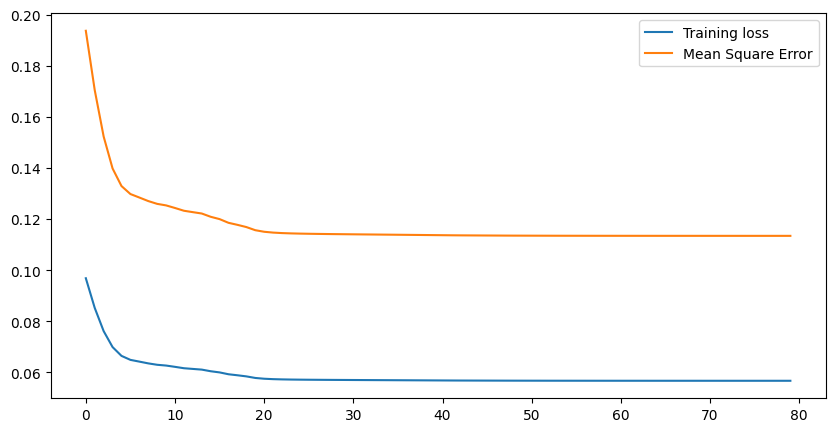

In [ ]:

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
cp1 = ModelCheckpoint('model_lstm/best_model.keras', save_best_only=True) # Changed filepath to include filename and .keras extension# Fit the model
history = model.fit(trainX_scaled, trainY_scaled, epochs=e, batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping,reduce_lr,cp1])

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['mean_squared_error'], label='Mean Square Error')
# plt.plot(history.history['RootMeanSquaredError'], label='RMSE')
plt.legend()

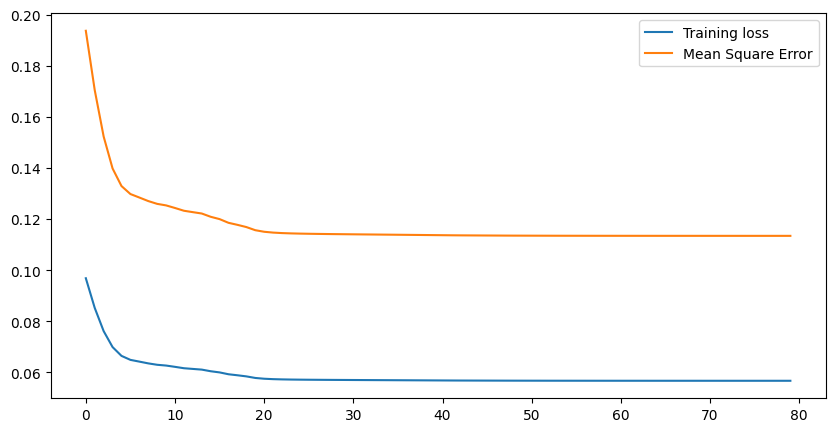

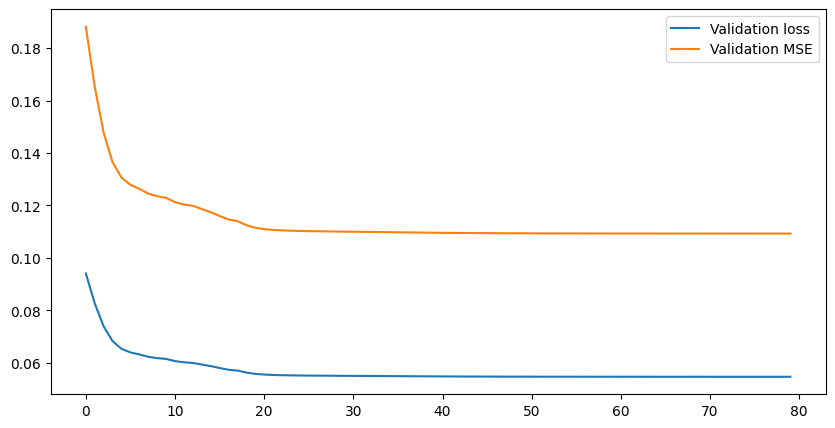

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['mean_squared_error'], label='Mean Square Error')
# plt.plot(history.history['RootMeanSquaredError'], label='RMSE')
plt.legend()

# Validaion
plt.figure(figsize=(10, 5))
plt.plot(history.history['val_loss'], label='Validation loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
# plt.plot(history.history['RootMeanSquaredError'], label='RMSE')
plt.legend()

**Evaluation**

In [ ]:
results = model.evaluate(testX_scaled, testY_scaled)
print(f"Test Loss: {results[0]}, Test MSE: {results[1]}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0702 - mean_squared_error: 0.1403
Test Loss: 0.06333969533443451, Test MSE: 0.12667939066886902


In [ ]:
# # Inverse transform to get the original 'ghi' values
# df_for_training['original_ghi'] = df_for_training_scaled_ghi * (max_value_ghi - min_value_ghi) + min_value_ghi
# print(df_for_training['original_ghi'])

0         0.353333
1        16.586666
2        77.518330
3       174.731670
4       281.553340
           ...    
9485     69.620000
9486      9.395000
9487      0.001667
9488      0.000000
9489      0.000000
Name: original_ghi, Length: 8967, dtype: float64


In [ ]:
# print(dataX_t)
# print(dataY_t)
print(testX_scaled.shape)
predictions = model.predict(testX_scaled)
print(predictions)
print(predictions.shape)
# predictions_ghi = predictions[:, :, 0]  # Select only GHI predictions
# print(predictions_ghi.shape)
# Create a dummy array with the same shape as original data
# y_pred_full = np.zeros((predictions.shape[0], predictions.shape[1], 3))

# Put predictions in the first column (GHI)
# y_pred_full[:, :, 0] = predictions

# print(predictions.shape)# Inverse transform using the same scaler
# y_pred_ghi_rescaled = scaler.inverse_transform(y_pred_full.reshape(-1, 3))[:, 0].reshape(predictions.shape[0], predictions.shape[1])

# #
predictions = scaler_testY.inverse_transform(predictions)
# dataX_t = scaler.inverse_transform(dataX_t)
# dataY_t = scaler.inverse_transform(dataY_t)
print(predictions[1])
print(predictions[1].shape)

print(testY_scaled[1])
print(testY_scaled[1].shape)


# print(dataX_t[1])
# print(dataX_t[1].shape)

(1747, 182, 3)
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[[0.35352212 0.38425994 0.         ... 0.         0.35164443 0.37128288]
 [0.34993988 0.38016784 0.         ... 0.         0.34840068 0.36593872]
 [0.34890518 0.37551516 0.         ... 0.         0.34636894 0.36166298]
 ...
 [0.3796696  0.36873025 0.         ... 0.         0.37501803 0.38049096]
 [0.37675834 0.37169862 0.         ... 0.         0.36973116 0.37998265]
 [0.3728463  0.37430114 0.         ... 0.         0.36309788 0.37914383]]
(1747, 52)
[317.0817  344.47134   0.      340.03116 321.2895    0.      339.05252
 325.6661  322.58484   0.      329.8029    0.      320.12875 324.47968
   0.      333.99023   0.      304.86346   0.      318.89133   0.
 312.8854  318.25635 313.5095  317.1923    0.      317.55264 322.73087
 316.54047 326.2043    0.      318.31293   0.      338.00742 331.9672
 329.6941  333.4578  342.17175 321.595     0.      338.46506 333.14658
 321.05084 321.78525 322.25375 316.53992 306.55966 322.27725 314.86768

In [ ]:
# # print(dataX_t)
# # print(dataY_t)
# print(X_test.shape)
# # print(X_test[:5])
# X_test_ghi = X_test[:,:,0]
# print(X_test_ghi.shape)
# X_test_ghi = X_test_ghi.reshape((X_test_ghi.shape[0],X_test_ghi.shape[1],1))
# # print(X_test_ghi)
# predictions = model.predict(X_test_ghi)
# # predictions = predictions.reshape(predictions.shape[0], predictions.shape[1], 1)  # Assuming you're predicting a single feature
# print(predictions)
# print(predictions.shape)

# # Reshape predictions to have a single feature dimension
# # predictions = predictions.reshape(-1, 1)
# # Create a temporary DataFrame with the single feature for inverse transform
# # predictions_df = pd.DataFrame(predictions, columns=['ghi'])
# # print(predictions.shape)
# predictions = scaler.inverse_transform(predictions)
# # dataX_t = scaler.inverse_transform(dataX_t)
# # dataY_t = scaler.inverse_transform(dataY_t)
# print(predictions[1])
# print(predictions[1].shape)

# print(y_test)
# print(y_test.shape)

# # print(dataX_t[1])
# # print(dataX_t[1].shape)

In [ ]:
# # Calculate RMSE

# # dataY_t_rescaled = scaler.inverse_transform(dataY_t.reshape(dataY_t.shape[0],dataY_t.shape[1]))
# # print(dataY_t_rescaled.shape)
# # print(dataY_t_rescaled)
# # print(predictions.shape)
# rmse = root_mean_squared_error(y_test.reshape(-1), predictions.reshape(-1))
# print("Root Mean Squared Error:", rmse)


# # calculate MAE
# mae = np.mean(np.abs(y_test[1] - predictions[1]))
# print("Mean Absolute Error (MAE):", mae)


dataY_t_rescaled = scaler_testY.inverse_transform(testY_scaled.reshape(testY_scaled.shape[0],testY_scaled.shape[1]))
print(dataY_t_rescaled.shape)
print(dataY_t_rescaled)
print(predictions.shape)
rmse = root_mean_squared_error(dataY_t_rescaled.reshape(-1), predictions.reshape(-1))
print("Root Mean Squared Error:", rmse)


# calculate MAE
mae = np.mean(np.abs(testY_scaled[1] - predictions[1]))
print("Mean Absolute Error (MAE):", mae)

(1747, 52)
[[3.0586500e+02 4.1218000e+02 5.1251500e+02 ... 2.9409167e+02
  3.9605000e+02 4.9471000e+02]
 [4.1218000e+02 5.1251500e+02 6.0043000e+02 ... 3.9605000e+02
  4.9471000e+02 5.8348500e+02]
 [5.1251500e+02 6.0043000e+02 6.7305170e+02 ... 4.9471000e+02
  5.8348500e+02 6.5294000e+02]
 ...
 [5.1016665e+00 0.0000000e+00 0.0000000e+00 ... 6.9620000e+01
  9.3950000e+00 1.6666670e-03]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.3950000e+00
  1.6666670e-03 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.0000000e-02 ... 1.6666670e-03
  0.0000000e+00 0.0000000e+00]]
(1747, 52)
Root Mean Squared Error: 322.50073897486067
Mean Absolute Error (MAE): 242.98717009173953


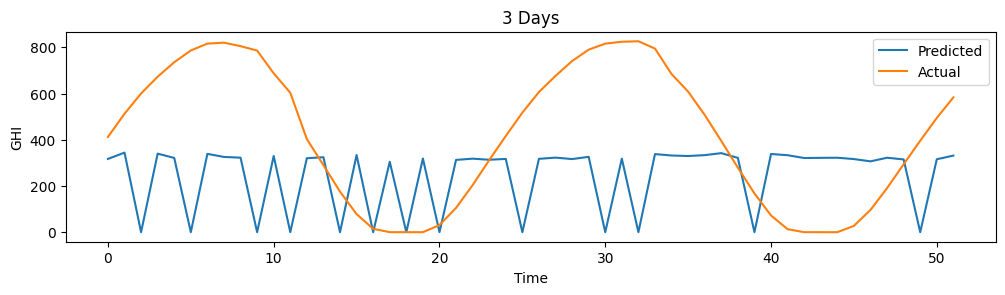

In [ ]:
# Split data into two days
TwoDays_predictions = predictions[1][:78]
# day2_predictions = predictions[1][26:]



TwoDays_test_y = dataY_t_rescaled[1][:78]
# day2_test_y = dataY_t[1][26:]
# TwoDays_test_y = scaler_testY.inverse_transform(TwoDays_test_y)
# day2_test_y = scaler.inverse_transform(day2_test_y)

# Plot the data
plt.figure(figsize=(12, 6))

# Day 1
plt.subplot(2, 1, 1)
plt.plot(TwoDays_predictions, label='Predicted')
plt.plot(TwoDays_test_y, label='Actual')
plt.title('3 Days')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.legend()

(52,)
(52, 1)


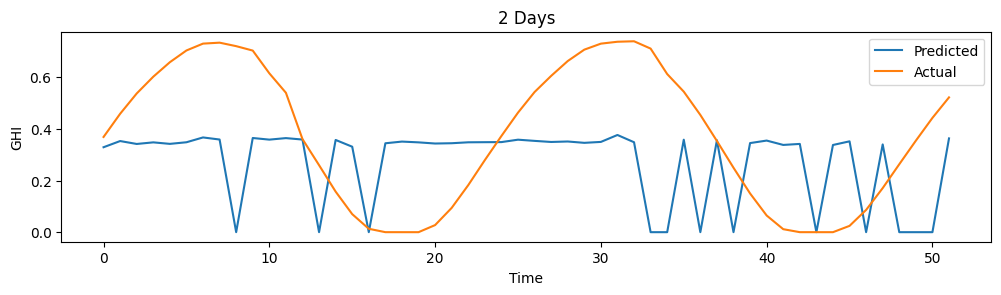

In [ ]:
# Split data into two days
TwoDays_predictions = predictions[1][:52]
# day2_predictions = predictions[1][26:]

TwoDays_test_y = y_test[1][:52]
# day2_test_y = y_test[1][26:]
# TwoDays_test_y = scaler.inverse_transform(TwoDays_test_y)
# day2_test_y = scaler.inverse_transform(day2_test_y)
print(TwoDays_predictions.shape)
print(TwoDays_test_y.shape)
# Plot the data
plt.figure(figsize=(12, 6))

# Day 1
plt.subplot(2, 1, 1)
plt.plot(TwoDays_predictions, label='Predicted')
plt.plot(TwoDays_test_y, label='Actual')
plt.title('2 Days')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.legend()